In [1]:
!pip install transformers datasets accelerate torch

In [2]:
from datasets import load_dataset
from datasets import Dataset
import pandas as pd

In [3]:
# Load the FEVER dataset
fever = load_dataset("fever", "v1.0")
train_data = fever["train"]
val_data = fever["labelled_dev"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
print("Length of training data: ", len(train_data))

Length of training data:  311431


In [5]:
print("Length of training data: ", len(val_data))

Length of training data:  37566


In [6]:
# Convert to pandas DataFrame for easier EDA
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

In [7]:
print("=== TRAIN DATA STATISTICS ===")
print(f"Number of rows: {len(train_df)}")
print("Label distribution:")
print(train_df['label'].value_counts())
print("\nSample rows from train dataset:")
print(train_df.head())

=== TRAIN DATA STATISTICS ===
Number of rows: 311431
Label distribution:
label
SUPPORTS           193756
REFUTES             70066
NOT ENOUGH INFO     47609
Name: count, dtype: int64

Sample rows from train dataset:
       id     label                                              claim  \
0   75397  SUPPORTS  Nikolaj Coster-Waldau worked with the Fox Broa...   
1   75397  SUPPORTS  Nikolaj Coster-Waldau worked with the Fox Broa...   
2  150448  SUPPORTS                 Roman Atwood is a content creator.   
3  150448  SUPPORTS                 Roman Atwood is a content creator.   
4  214861  SUPPORTS  History of art includes architecture, dance, s...   

   evidence_annotation_id  evidence_id         evidence_wiki_url  \
0                   92206       104971     Nikolaj_Coster-Waldau   
1                   92206       104971  Fox_Broadcasting_Company   
2                  174271       187498              Roman_Atwood   
3                  174271       187499              Roman_Atwood   

In [8]:
# Basic statistics for validation data
print("\n=== VALIDATION DATA STATISTICS ===")
print(f"Number of rows: {len(val_df)}")
print("Label distribution:")
print(val_df['label'].value_counts())
print("\nSample rows from validation dataset:")
print(val_df.head())



=== VALIDATION DATA STATISTICS ===
Number of rows: 37566
Label distribution:
label
SUPPORTS           14608
REFUTES            14017
NOT ENOUGH INFO     8941
Name: count, dtype: int64

Sample rows from validation dataset:
       id            label                                              claim  \
0   91198  NOT ENOUGH INFO  Colin Kaepernick became a starting quarterback...   
1  194462  NOT ENOUGH INFO                          Tilda Swinton is a vegan.   
2  137334         SUPPORTS     Fox 2000 Pictures released the film Soul Food.   
3  137334         SUPPORTS     Fox 2000 Pictures released the film Soul Food.   
4  137334         SUPPORTS     Fox 2000 Pictures released the film Soul Food.   

   evidence_annotation_id  evidence_id         evidence_wiki_url  \
0                  108548           -1                             
1                  227768           -1                             
2                  289914       283015  Soul_Food_-LRB-film-RRB-   
3                 

In [9]:
# Descriptive statistics for train data
print("=== TRAIN DATA DESCRIPTIVE STATISTICS ===")
print(train_df.describe())

=== TRAIN DATA DESCRIPTIVE STATISTICS ===
                  id  evidence_annotation_id    evidence_id  \
count  311431.000000           311431.000000  311431.000000   
mean   103887.226609           165265.242747  142264.874370   
std     64062.800149            96016.521817  102544.102742   
min         3.000000            11112.000000      -1.000000   
25%     49391.500000            82627.000000   49349.500000   
50%    100468.000000           156355.000000  137966.000000   
75%    153054.000000           248819.500000  231578.500000   
max    229449.000000           345076.000000  328496.000000   

       evidence_sentence_id  
count         311431.000000  
mean               4.083566  
std                7.168102  
min               -1.000000  
25%               -1.000000  
50%                1.000000  
75%                7.000000  
max               74.000000  


In [11]:
from collections import Counter

# Count class occurrences in the training dataset
label_counts = Counter(train_data["label"])

# Total number of samples
total_samples = len(train_data["label"])

# Calculate and print the percentage for each class
for label, count in label_counts.items():
    percentage = (count / total_samples) * 100
    print(f"Class '{label}': {count} samples, {percentage:.2f}%")

Class 'SUPPORTS': 193756 samples, 62.21%
Class 'REFUTES': 70066 samples, 22.50%
Class 'NOT ENOUGH INFO': 47609 samples, 15.29%


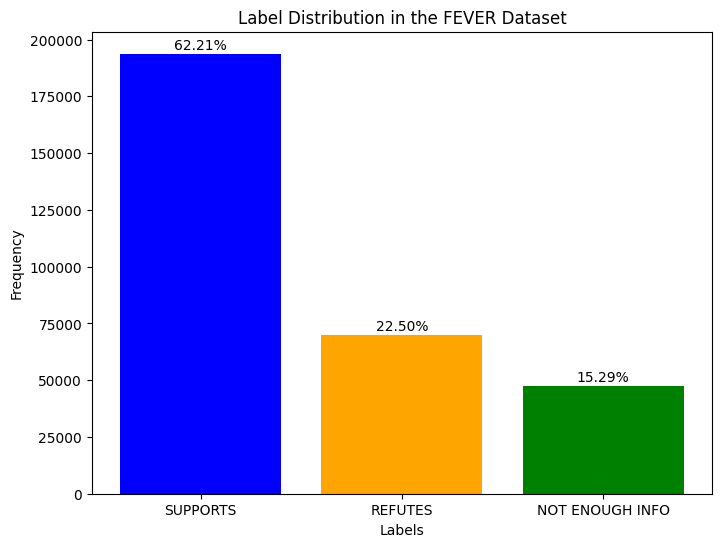

In [12]:
import matplotlib.pyplot as plt
from collections import Counter

# Count class occurrences in the training dataset
label_counts = Counter(train_data["label"])

# Total number of samples
total_samples = len(train_data["label"])

# Prepare data for the plot
labels = list(label_counts.keys())
counts = list(label_counts.values())
percentages = [(count / total_samples) * 100 for count in counts]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=["blue", "orange", "green"])

# Set plot labels and title
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Label Distribution in the FEVER Dataset')

# Add percentages on top of bars
for i, (count, percentage) in enumerate(zip(counts, percentages)):
    plt.text(i, count + 500, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=10)

# Display the plot
plt.show()


### Balancing the classes of the dataset

In [13]:
# Function to sample equal examples for each class
def balance_classes(dataset, label_column):
    # Find the minimum number of samples across all classes
    label_counts = Counter(dataset[label_column])
    min_samples = min(label_counts.values())  # Smallest class count

    balanced_data = []
    for label in label_counts.keys():
        # Filter examples for the current class
        class_samples = dataset.filter(lambda x: x[label_column] == label)
        # Sample `min_samples` examples
        balanced_data.append(class_samples.select(range(min(min_samples, len(class_samples)))))

    # Combine all balanced class samples
    return Dataset.from_dict({key: sum([d[key] for d in balanced_data], []) for key in dataset.column_names})

# Balance the training and validation datasets
train_data = balance_classes(fever["train"], "label")
# labelled_dev_list = list(fever["labelled_dev"])
# val_data = labelled_dev_list[:14282]
val_data = fever["labelled_dev"].select(range(14282))

print(f"Training examples: {len(train_data)}, Validation examples: {len(val_data)}")

Filter:   0%|          | 0/311431 [00:00<?, ? examples/s]

Filter:   0%|          | 0/311431 [00:00<?, ? examples/s]

Filter:   0%|          | 0/311431 [00:00<?, ? examples/s]

Training examples: 142827, Validation examples: 14282


In [17]:
from collections import Counter

# Count class occurrences in the training dataset
label_counts = Counter(train_data["label"])

# Total number of samples
total_samples = len(train_data["label"])

# Calculate and print the percentage for each class
for label, count in label_counts.items():
    percentage = (count / total_samples) * 100
    print(f"Class '{label}': {count} samples, {percentage:.2f}%")

Class 'SUPPORTS': 47609 samples, 33.33%
Class 'REFUTES': 47609 samples, 33.33%
Class 'NOT ENOUGH INFO': 47609 samples, 33.33%


In [15]:
for i in range(5):
    claim = train_data["claim"][i]
    label = train_data["label"][i]
    print(f"Claim {i + 1}: {claim}")
    print(f"Label {i + 1}: {label}")
    print("-----")

Claim 1: Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.
Label 1: SUPPORTS
-----
Claim 2: Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.
Label 2: SUPPORTS
-----
Claim 3: Roman Atwood is a content creator.
Label 3: SUPPORTS
-----
Claim 4: Roman Atwood is a content creator.
Label 4: SUPPORTS
-----
Claim 5: History of art includes architecture, dance, sculpture, music, painting, poetry literature, theatre, narrative, film, photography and graphic arts.
Label 5: SUPPORTS
-----


In [16]:
label2id = {"SUPPORTS": 0, "REFUTES": 1, "NOT ENOUGH INFO": 2}
id2label = {v: k for k, v in label2id.items()}
# Retrieve one example for each label
for label_name, label_id in label2id.items():
    # Filter the dataset to get one example for each label
    sample = train_data.filter(lambda x: label2id[x["label"]] == label_id).select([0])  # Select the first example for each label
    claim = sample["claim"][0]
    label = sample["label"][0]

    # Print the claim and its label
    print(f"Label: {label_name}")
    print(f"Claim: {claim}")
    print(f"Label ID: {label}")
    print("-----")


Filter:   0%|          | 0/142827 [00:00<?, ? examples/s]

Label: SUPPORTS
Claim: Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.
Label ID: SUPPORTS
-----


Filter:   0%|          | 0/142827 [00:00<?, ? examples/s]

Label: REFUTES
Claim: Adrienne Bailon is an accountant.
Label ID: REFUTES
-----


Filter:   0%|          | 0/142827 [00:00<?, ? examples/s]

Label: NOT ENOUGH INFO
Claim: System of a Down briefly disbanded in limbo.
Label ID: NOT ENOUGH INFO
-----
